In [16]:
import numpy as np
score = np.array([0., 0.])

# MHBF Programming Tutorial Week 

## Saliency

### Alicja Krześniak and Jan Boelts
#### Please provide comments, thanks! 

### Exercise 1: Saliency Maps from Local Standard Deviation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv
from scipy.stats import circstd
from scipy.signal import fftconvolve, convolve2d
from helper import gaussian_filter, mexican_hat
from os import listdir
%matplotlib inline

In [2]:
img = plt.imread("salience/salience_09.png")
img2 = plt.imread("salience/salience_08.png")
height, width, channels = img.shape

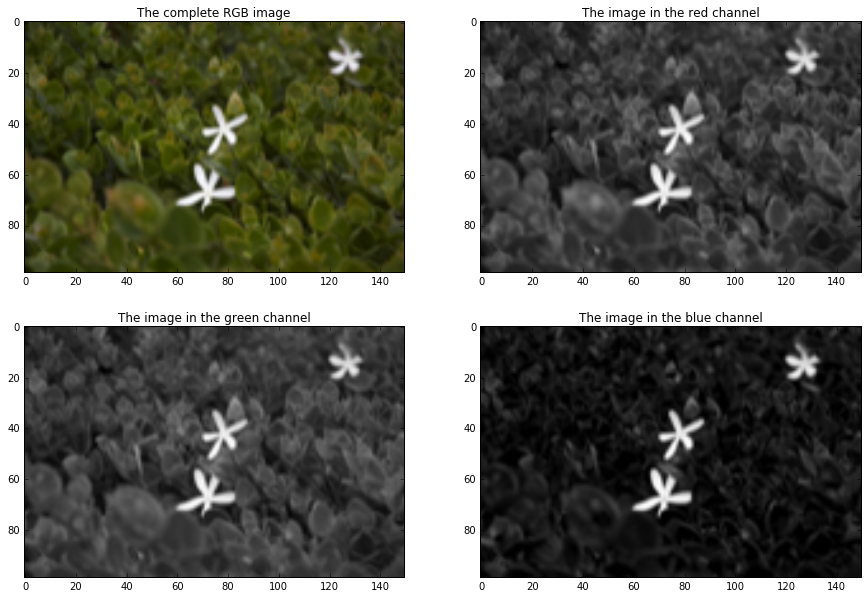

In [3]:
# Plot the color image as well as the three channels separately as a gray level image into a single figure
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(img)
plt.title("The complete RGB image")
colors = ["red", "green", "blue"]
for i in range(3): 
    plt.subplot(2,2,i+2)
    plt.imshow(img[:,:,i], cmap='gray')
    plt.title("The image in the " + colors[i] + " channel")

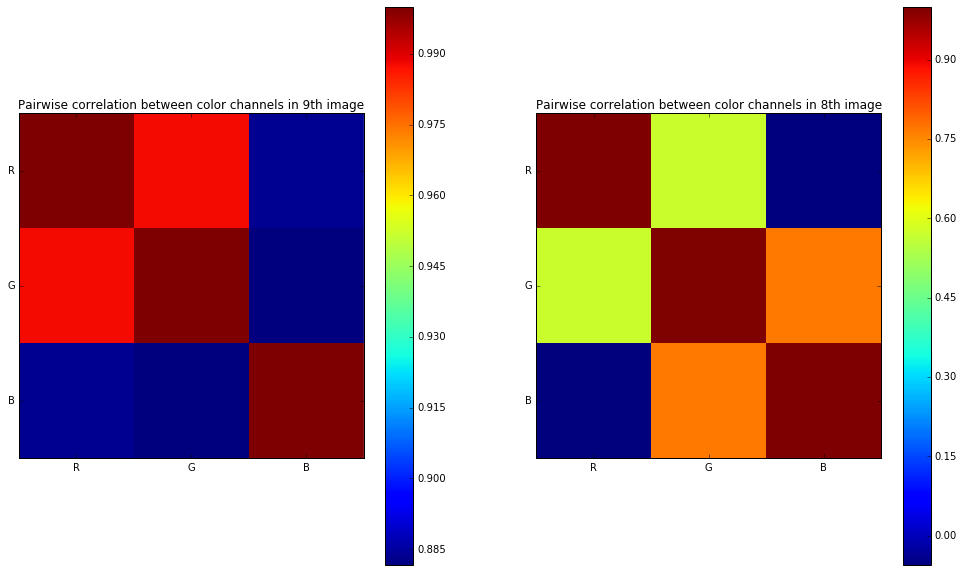

In [4]:
def img_channel_corr(img): 
    """Compute pairwise correlation between channels over all pixel values"""
    width, height, channels = img.shape
    # use the function flatten to convert each image channel into a vector
    img_mat = np.zeros((channels, width*height))
    for i in range(channels): 
        # stack vectors in a matrix
        img_mat[i,:] = img[:,:,i].flatten()
    # then apply corrcoeff to obtain all pairwise correlation coefficients
    return np.corrcoef(img_mat)
# use function defined above
img_corr = img_channel_corr(img)
img_corr2 = img_channel_corr(img2)
# visualize 
plt.figure(figsize=(17,10))
plt.subplot(121)
plt.imshow(img_corr, interpolation='none')
plt.colorbar()
plt.title("Pairwise correlation between color channels in 9th image")
plt.xticks(range(3), ["R", "G", "B"])
plt.yticks(range(3), ["R", "G", "B"]);

plt.subplot(122)
plt.imshow(img_corr2, interpolation='none')
plt.colorbar()
plt.title("Pairwise correlation between color channels in 8th image")
plt.xticks(range(3), ["R", "G", "B"])
plt.yticks(range(3), ["R", "G", "B"]);

#### Is there anything striking in the correlations?
Correlation values between all the channels are high (0.88-0.98) and the correlation with blue channel is the lowest (except from the obvious correlation = 1 in the blue-blue slot). However in the salience_08 image all pairwise correlations aren't so high, and blue-red correlation is close to 0.

#### Why is this not surprising given the way natural images arise?
Blurred natural images contains often almost full range of colours and a lot of black and white shades (so the have high red, blue and green component). It's very unlikely to see pure RGB colour in natural world. Most of the natural images contains not so much violet colour, it could be a clue why in both situations red-blue correlation is the lowest.

#### Tutorial 
natural light is full-spectrum (white light, all colors are present)--> strong correlations at illuminated locations

In [17]:
score += [3., 3.]; score

array([ 3.,  3.])

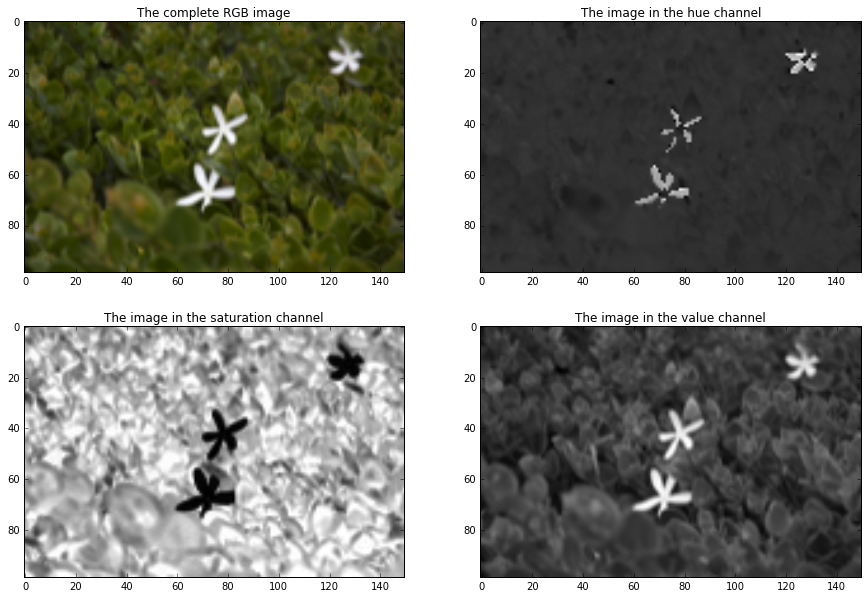

In [5]:
# convert the image from RGB- to HSV-space
img_hsv = rgb_to_hsv(img)
# plot the three channels separately as gray level images into a single figure together with the color image.
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(img)
plt.title("The complete RGB image")
strings = ["hue", "saturation", "value"]
for i in range(3): 
    plt.subplot(2,2,i+2)
    plt.imshow(img_hsv[:,:,i], cmap='gray')
    plt.title("The image in the " + strings[i] + " channel")

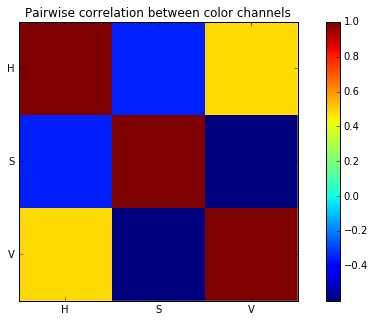

In [6]:
# compute the pairwise correlation coefficients between the new HSV-channels
img_corr_hsv = img_channel_corr(img_hsv)
# visualize 
plt.figure(figsize=(10,5))
f = plt.imshow(img_corr_hsv, interpolation='none')
plt.colorbar(f)
plt.title("Pairwise correlation between color channels")
plt.xticks(range(3), ["H", "S", "V"])
plt.yticks(range(3), ["H", "S", "V"]);

#### Why there is less correlation now?
Now we are comparing different features of colours in the image, so there is less redundancy between the channels.

We will now compute three independent saliency maps for the image using the HSV-representation.

#### Tutorial 
why less correlated? because color is more or les independent from illumination. hue and value are a bit correlated due to their definition. 

In [18]:
score += [1.5, 2.]; score # But why are they less correlated? What makes them "different features"?

array([ 4.5,  5. ])

In [7]:
# decompose the image into the separate HSV- channels
img_h = img_hsv[:,:,0]
img_s = img_hsv[:,:,1]
img_v = img_hsv[:,:,2]
def get_patch(img, px, py, patchsize): 
    """Extract a patch of size patchsize from the image img at pixels location (px,py)"""
    # make sure to use even patchsize 
    assert(np.mod(patchsize, 2))
    # ignore edge pixels 
    half_patch = int(patchsize/2)
    # get params
    height, width = img.shape
    # make sure the location is not near the edge 
    assert(px-half_patch>-1)
    assert(px+half_patch<=height)
    assert(py-half_patch>-1)
    assert(py+half_patch<=width)
    # get idx 
    return img[(px-half_patch):(px+half_patch+1), (py-half_patch):(py+half_patch+1)]

In [8]:
# patch size 
patchsize = 15
# pixels to be ignored
px_ignore = int(patchsize/2)
img_sal = np.zeros((height-patchsize, width-patchsize, channels))
print(img_sal.shape)
for i in range(img_sal.shape[0]): 
    for j in range(img_sal.shape[1]): 
        # move away from edges
        px = i + px_ignore
        py = j + px_ignore
        # get the patches 
        patch_h = get_patch(img_h, px, py, patchsize)
        patch_s = get_patch(img_s, px, py, patchsize)
        patch_v = get_patch(img_v, px, py, patchsize)
        # save the std of the patch as new image
        img_sal[i, j, 0] = circstd(patch_h, high=1)
        img_sal[i, j, 1] = np.std(patch_s)
        img_sal[i, j, 2] = np.std(patch_v)       

(84, 135, 3)


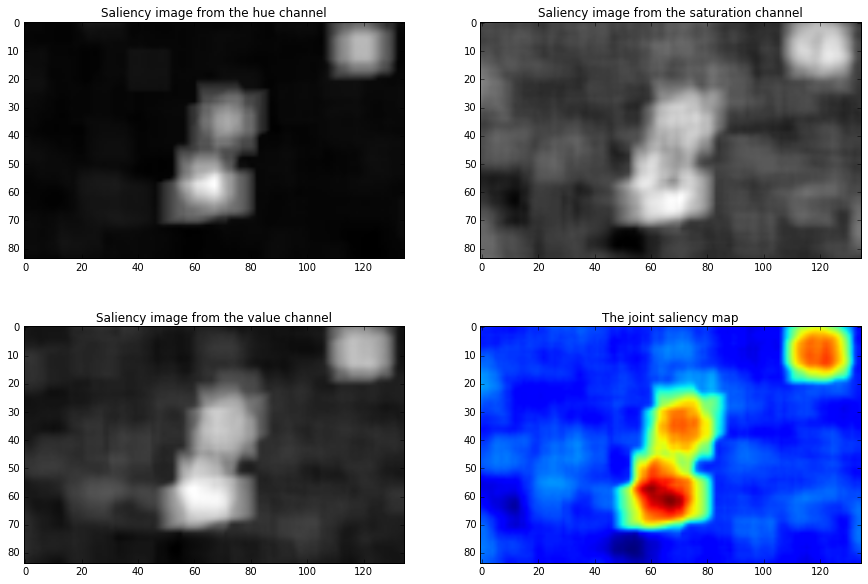

In [9]:
# Plot the separate saliency images into a single figure
plt.figure(figsize=(15,10))
strings = ["hue", "saturation", "value"]
for i in range(3): 
    plt.subplot(2,2,i+1)
    plt.imshow(img_sal[:,:,i], cmap='gray')
    plt.title("Saliency image from the " + strings[i] + " channel")
# Compute a joint saliency map by summing the separate saliency images
sal_map = img_sal.sum(axis=2)    
# Add the joint saliency map to the previous figure.
plt.subplot(224)
plt.imshow(sal_map)
plt.title("The joint saliency map")


#### How is each of the three images related to the visual properties of the image?
They all show difference in brightness and colour in the image. They strengthen areas with properties diefferent than in the background (here the placement of white flower on green leaves).

### Tutorial 
indexing: img_hsv[...,i] graps all first n-1 axes and takes the ith index of the last axis. 

hue saliency: complex objects, foreground background edges

saturation saliency: changes in luminosity or reflections

value saliency: shadow edges and high constrast objects 

pass a tuple to a function: `gaussian_filter(*sal_map.shape, **{sigma=3})` instead of `gaussian_filter(sal_map.shape[0], sal_map.shape[1], sigma=3)`

In [19]:
score += [2.5, 3.]; score # Aside from foreground-background, what else might it detect?

array([ 7.,  8.])

In [10]:
# smooth this image by low-pass filtering
kernel = gaussian_filter(sal_map.shape[0], sal_map.shape[1], sigma=3)
sal_map_smooth = fftconvolve(sal_map, kernel, mode='same')

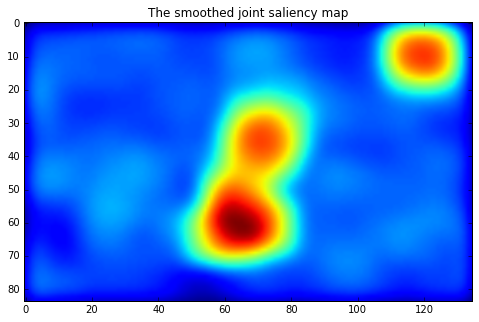

In [11]:
# Plot the result into a new figure.
plt.figure(figsize=(10,5))
plt.title("The smoothed joint saliency map")
plt.imshow(sal_map_smooth);

In [20]:
score += [2., 2.]; score

array([  9.,  10.])

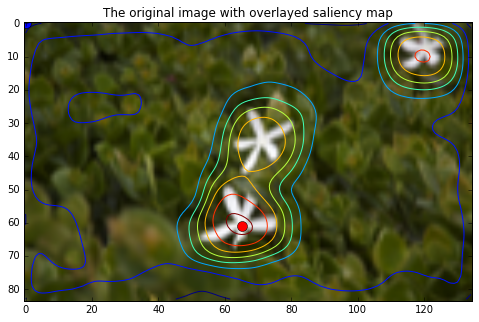

In [12]:
# plot the original image and overlay the contours of the smoothed saliency map
plt.figure(figsize=(10,5))
plt.title("The original image with overlayed saliency map")
plt.imshow(img[px_ignore:-(px_ignore+1), px_ignore:-(px_ignore+1)])
plt.contour(sal_map_smooth);
# extract the positions the subject will most likely and least likely look at
(xmax, ymax) = np.unravel_index(np.argmax(sal_map_smooth.flatten()), dims=sal_map_smooth.shape)
(xmin, ymin) = np.unravel_index(np.argmin(sal_map_smooth.flatten()), dims=sal_map_smooth.shape)
# Mark those points with a red and blue dot, respectively
plt.plot(ymax, xmax, 'ro', ms = 10)
plt.plot(ymin, xmin, 'bo', ms = 10);

#### How do you interpret the completed image?
The completed image shows where it is the most and the least probable to look first when seeing this picture. The map shows features that have higher saliency and "catch eye". It is very likely to look first on the flowers in this image, because they have different colour and brightness than other objects on the photo. The least likely patch to notice is upper left corner.

In [21]:
score += [2., 2.]; score

array([ 11.,  12.])

In [13]:
# wrap all the above in function 
def compute_saliency_map(img): 
    """Compute saliency map from RGB image"""
    height, width, channels = img.shape
    # convert the image from RGB- to HSV-space
    img_hsv = rgb_to_hsv(img)
    # patch size 
    patchsize = 15
    # pixels to be ignored
    px_ignore = int(patchsize/2)
    img_sal = np.zeros((height-patchsize, width-patchsize, channels))
    for i in range(img_sal.shape[0]): 
        for j in range(img_sal.shape[1]): 
            # save the std of the patch as new image
            img_sal[i, j, 0] = circstd(get_patch(img_hsv[:,:,0], i + px_ignore, j + px_ignore, patchsize), high=1)
            img_sal[i, j, 1] = np.std(get_patch(img_hsv[:,:,1], i + px_ignore, j + px_ignore, patchsize))
            img_sal[i, j, 2] = np.std(get_patch(img_hsv[:,:,2], i + px_ignore, j + px_ignore, patchsize))  
    # Compute a joint saliency map, smooth and return
    kernel = gaussian_filter(sal_map.shape[0], sal_map.shape[1], sigma=3)
    return fftconvolve(img_sal.sum(axis=2), kernel, mode='same')

def plot_saliency_map(img, sal_map, filename, px_ignore=7): 
    """Plots saliency map on top of original image, marks most salient points"""
    plt.title("Image file {}".format(filename), fontsize=15)
    plt.imshow(img[px_ignore:-(px_ignore+1), px_ignore:-(px_ignore+1)])
    plt.contour(sal_map);
    # extract the positions the subject will most likely and least likely look at
    (xmax, ymax) = np.unravel_index(np.argmax(sal_map.flatten()), dims=sal_map.shape)
    (xmin, ymin) = np.unravel_index(np.argmin(sal_map.flatten()), dims=sal_map.shape)
    # Mark those points with a red and blue dot, respectively
    plt.plot(ymax, xmax, 'ro', ms = 10)
    plt.plot(ymin, xmin, 'bo', ms = 10);

In [14]:
# Repeat the above procedures to plot a saliency map onto the complete set of color images provided
img_list = listdir("salience/")
# compute maps 
sal_maps = np.zeros((84,135,20))
for i, img_file in enumerate(img_list): 
    img = plt.imread("salience/" + img_file)
    sal_maps[:,:,i] = compute_saliency_map(img)

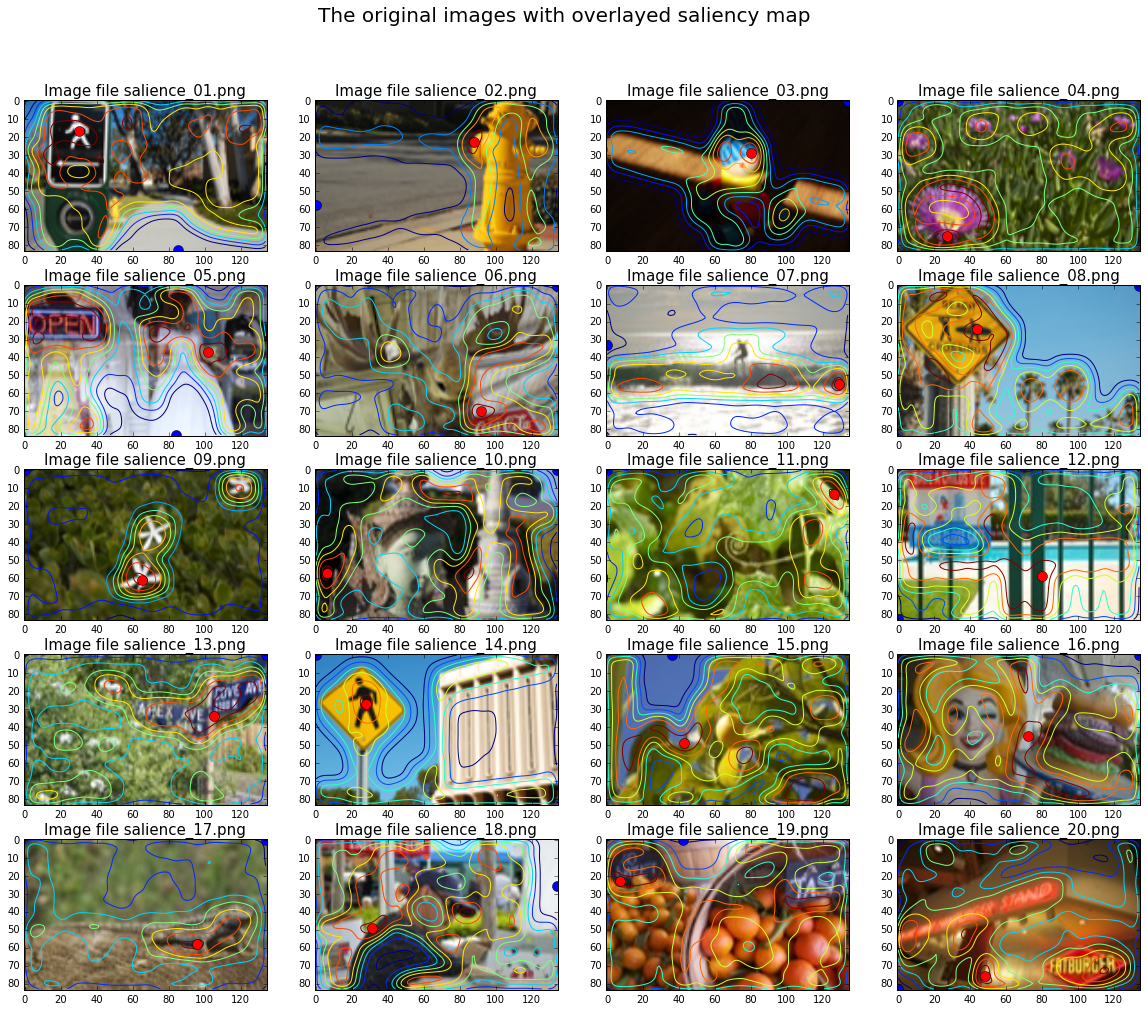

In [15]:
# plot maps
plt.figure(figsize=(20,16))
for i, img_file in enumerate(img_list): 
    plt.subplot(5,4,i+1)
    img = plt.imread("salience/" + img_file)
    plot_saliency_map(img, sal_map=sal_maps[:,:,i], filename=img_file)
plt.suptitle("The original images with overlayed saliency map", fontsize=20);

#### Do you observe a general pattern in the results?
Generally results show patches with very high colour difference as places with the highest saliency. The smallest saliency (blue dot) is most often on the edge of the photo.

#### Are there any images that give unexpected saliency maps?
Image 7, 12 and 20

#### Which potentially salient image features are not taken into account in the above saliency algorithm?
People and faces 

#### Please outline in words how the information that subjects are much more likely to ﬁrst attend the center of an image, instead of the borders, could be included in the above saliency-map analysis to better predict eye-movements.
We can weight the final saliency map with 2-dimensional Gaussian, so that saliency values in the center get higher than without the filter (and respectively edges hve smaller values)

In [22]:
score += [2., 2.]; score

array([ 13.,  14.])

### Exercise 2: Mexican-hat convolution

In [ ]:
# get the image 
img = plt.imread("salience/salience_09.png")
xsize, ysize, channels = img.shape
# build the kernel
mex_kernel = mexican_hat(xsize, ysize, width=3)
# get hsv image
img_hsv = rgb_to_hsv(img)
# Convolve the image with the prepared “mexican hat” filter
sal_map = np.zeros_like(img_hsv)
for i in range(3): 
    sal_map[:,:,i] = np.abs(convolve2d(img_hsv[:,:,i], mex_kernel, mode='same', boundary='symm'))


In [ ]:
# Plot the separate saliency images into a single figure
plt.figure(figsize=(15,10))
strings = ["hue", "saturation", "value"]
for i in range(3): 
    plt.subplot(2,2,i+1)
    plt.imshow(sal_map[:,:,i], cmap='gray')
    plt.title("Saliency image from the " + strings[i] + " channel")   
# Add the joint saliency map to the previous figure.
plt.subplot(224)
plt.imshow(img_sal.sum(axis=2))
plt.title("The joint saliency map");

#### Try out what happens with different boundary conditions and explain which one produces the best result.
There are no strong differences that can be seen with different parameters

####  In which aspects do the saliency maps obtained by convolution diﬀer from the saliency maps that you obtained by computing standard deviation on image patches. Can you give an intuition why?
Here we can see contours and edges in the HSV channels, but the joint map is very similar to the previous one. The mexican hat filtering gives black lines, because it weights some of the surrounding pixels negatively. 

In [ ]:
# wrap the above in a function
def compute_mexican_salience(img): 
    xsize, ysize, channels = img.shape
    # build the kernel
    mex_kernel = mexican_hat(xsize, ysize, width=3)
    smooth_kernel = gaussian_filter(xsize, ysize, sigma=3)
    # get hsv image
    img_hsv = rgb_to_hsv(img)
    # Convolve the image with the prepared “mexican hat” filter
    sal_map = np.zeros_like(img_hsv)
    for i in range(3): 
        sal_map[:,:,i] = np.abs(convolve2d(img_hsv[:,:,i], mex_kernel, mode='same', boundary='symm'))
    return fftconvolve(sal_map.sum(axis=2), smooth_kernel, mode='same')

def plot_mexican_salience(img, sal_map, filename): 
    """Plots saliency map on top of original image, marks most salient points"""
    plt.title("Image file {}".format(filename), fontsize=15)
    plt.imshow(img)
    plt.contour(sal_map);
    # extract the positions the subject will most likely and least likely look at
    (xmax, ymax) = np.unravel_index(np.argmax(sal_map.flatten()), dims=sal_map.shape)
    (xmin, ymin) = np.unravel_index(np.argmin(sal_map.flatten()), dims=sal_map.shape)
    # Mark those points with a red and blue dot, respectively
    plt.plot(ymax, xmax, 'ro', ms = 10)
    plt.plot(ymin, xmin, 'bo', ms = 10);

In [ ]:
# Repeat the above procedures to plot a saliency map onto the complete set of color images provided
img_list = listdir("salience/")
# compute maps 
sal_maps = np.zeros((99,150,20))
for i, img_file in enumerate(img_list): 
    img = plt.imread("salience/" + img_file)
    sal_maps[:,:,i] = compute_mexican_salience(img)

In [ ]:
# plot maps
plt.figure(figsize=(20,16))
for i, img_file in enumerate(img_list): 
    plt.subplot(5,4,i+1)
    img = plt.imread("salience/" + img_file)
    plot_mexican_salience(img, sal_map=sal_maps[:,:,i], filename=img_file)
plt.suptitle("The original images with overlayed mexican saliency map", fontsize=20);

#### Do you think that computing the standard deviation across patches is a valid shortcut?
Yes, it is a valid shortcut, because it gives reasonable results for the whole set of natural images.

#### What is the disadvantage of using the convolution technique on HSV-represented images?
It takes longer. Red dot is more often not in the center of the image.

#### Tutorial: Shirtcomings: 
does not find special saliency: animals, faces, text. high level objects that fail to produce high local HSV variance will be missed. Size, proximity and movement are ignored. 

Filter banks or mexican hat models do not significantly outperform simple approaches like the std approach. 

In [23]:
score += [1., 0.]; score # bonus point

array([ 14.,  14.])